# Финальный проект. AVITO
### Костяницына Анатасия, БКЛ-151

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

Загрузим данные

In [4]:
train = pd.read_csv("train.csv", parse_dates=["activation_date"])
test = pd.read_csv("test.csv", parse_dates=["activation_date"])

In [5]:
test = pd.read_csv("test.csv", parse_dates=["activation_date"])

In [6]:
y = train['deal_probability']

In [7]:
ids = test.item_id

In [ ]:
#y = np.asarray(train['deal_probability'], dtype="|S6")

Посмотрим на данные

In [9]:
train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [20]:
train.shape

(1503424, 18)

In [19]:
test.shape

(508438, 17)

Посмотим какие значения принимает deal_probability

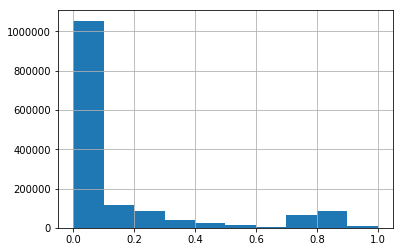

In [11]:
train.deal_probability.hist()

Как видно, больше всего объявлений с 0 вероятностью отклика.

1. небольшое описание каждого из признаков, которые вы использовали в своей модели (например, что за тип данных, есть ли nanы, какие-то поверхностные хар-ки вроде мин,макс длины текста, топ употребляемых слов и т.д. )

Кажется, что наиболее значимыми являются описание предложений (description) и название объявления (title), так как именно по ним пользователь выбирает нужный вариант в рамках конкртной категории.

Есть ли пропуски в данных?

In [18]:
pd.DataFrame({'':['train', 'test'],
             'title':[train.title.isnull().sum().sum(),
                       test.title.isnull().sum().sum()],
             'Description': [train.description.isnull().sum().sum(),
                             test.description.isnull().sum().sum()]})

,,Description,title
0,train,116276,0
1,test,0,0


У многих объявлений из обучающей выборки нет описания. Кажется, что не стоит удалять такие строки на этом этапе, так как мы title у них присутвует, значит они все еще валидны для исследования. Однако данных слишком много, поэтому, удалив их, мы сможем несколько сократить размерность.

Заполним пропуски

In [8]:
train["description"].fillna("NA", inplace=True)

Стоит учитывать также то, что чрезмерно короткий или чрезмерно длинный текст описания может отпугнуть покупателей. Посмотрим, есть ли какая-то зависимость. 

In [169]:
train['des_length'] = train['description'].apply(len)

In [170]:
train['tit_length'] = train['title'].apply(len)

In [171]:
test['des_length'] = test['description'].apply(len)
test['tit_length'] = test['title'].apply(len)

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline 

Группирую вероятности и длины. Беру среднее между вероятностью текстов с одной длиной.

In [79]:
result = train.sort_values(['des_length'])
result = result[['des_length', 'deal_probability']]
print(result.shape)
result.drop_duplicates(result)
result = result.groupby('des_length', as_index=False)['deal_probability'].mean()

(1503424, 2)


In [80]:
print(result.shape)

(3093, 2)


In [87]:
result2 = train.sort_values(['tit_length'])
result2 = result2[['tit_length', 'deal_probability']]
print(result2.shape)
result2.drop_duplicates(result2, inplace=True)
result2 = result2.groupby('tit_length', as_index=False)['deal_probability'].mean()

(1503424, 2)


In [ ]:
print(result2.shape)

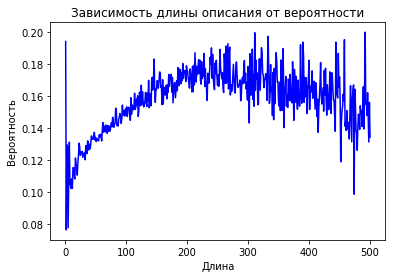

In [84]:
plt.plot(result.des_length.values[:500], result.deal_probability.values[:500], color="blue")
plt.title('Зависимость длины описания от вероятности')
plt.xlabel('Длина')
plt.ylabel('Вероятность')

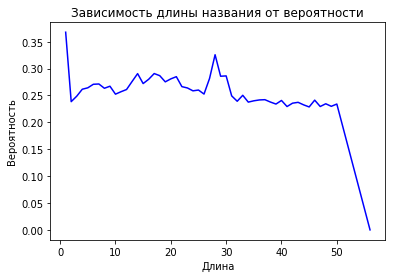

In [89]:
plt.plot(result2.tit_length.values[:500], result2.deal_probability.values[:500], color="blue")
plt.title('Зависимость длины названия от вероятности')
plt.xlabel('Длина')
plt.ylabel('Вероятность')

Кажется, что все же есть некоторая корреляция между признаками. Так что добавим такой признак.

In [92]:
pd.DataFrame({'':['Описание', 'Название'], 'Минимальная длина':[np.min(train.des_length), np.min(train.tit_length)],
             'Средняя длина':[np.mean(train.des_length), np.mean(train.tit_length)],
             'Максимальная длина':[np.max(train.des_length), np.max(train.tit_length)]})

,,Максимальная длина,Минимальная длина,Средняя длина
0,Описание,3212,1,178.125376
1,Название,56,1,21.393126


In [94]:
del result, result2

### Преобразование данных

Для преобразования данных будем использовать два способова: CountVectorizer и TfidfVectorizer

#### TfidfVectorizer

Соединим описания и удалим пропуски.

In [9]:
a = pd.concat([train['description'], test['description']])
all_des = pd.DataFrame(a)
all_des = all_des[all_des.description != 'NA']

In [10]:
all_tit = pd.concat([train['title'], test['title']])

In [11]:
all_des.shape

(1895586, 1)

In [12]:
all_tit.shape

(2011862,)

Чтобы чуть уменьшить размерность, будем удалять стоп слова.

In [15]:
from nltk.corpus import stopwords

In [16]:
stops = stopwords.words('russian')

Сначала попробуем проанализировать по словам

In [20]:
f = open('all.txt', 'a', encoding='utf-8')
for i in a:
    if i == 'NA':
        continue
    else:
        f.write(i + '\n')
f.close()

#### Попробовать снять омонимию

In [21]:
from pymystem3 import Mystem

mystem = Mystem()

In [23]:
mystem.lemmatize('мама мыла раму')

['мама', ' ', 'мыть', ' ', 'рама', '\n']

In [25]:
mystem.analyze('мама мыла раму')

[{'analysis': [{'gr': 'S,жен,од=им,ед', 'lex': 'мама'}], 'text': 'мама'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=прош,ед,изъяв,жен', 'lex': 'мыть'}],
  'text': 'мыла'},
 {'text': ' '},
 {'analysis': [{'gr': 'S,жен,неод=вин,ед', 'lex': 'рама'}], 'text': 'раму'},
 {'text': '\n'}]

##### Description

In [17]:
des_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words=stops,
    lowercase=True,
    ngram_range=(1, 1),
    max_features=20000)

In [18]:
des_vectorizer.fit(all_des['description'])
train_word_features = des_vectorizer.transform(train['description'])
test_word_features = des_vectorizer.transform(test['description'])

In [19]:
train_word_features.shape

(1503424, 20000)

In [ ]:
(1503424, 20000)

##### Title

In [20]:
tit_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words=stops,
    lowercase=True,
    ngram_range=(1, 1),
    max_features=2000)

tit_vectorizer.fit(all_tit)
train_tit_features = tit_vectorizer.transform(train['title'])
test_tit_features = tit_vectorizer.transform(test['title'])

In [21]:
train_tit_features.shape

(1503424, 2000)

In [ ]:
(1503424, 2000)

In [129]:
del train, test

Попробуем сократить размерность с помощью PCA

#### Обучение

Так как значения y у нас не классы, а вероятности, то задача классификации здесь не подходит. 

Разделим выборку на обучающую и тестовую.

In [26]:
from scipy.sparse import hstack

#### Без учета длин

In [27]:
train_features = hstack([train_tit_features, train_word_features])
test_features = hstack([test_tit_features, test_word_features])

In [140]:
train_features.shape

(1503424, 22000)

In [214]:
X_train, X_test, y_train, y_test = train_test_split(train_features, y, test_size=0.33, random_state=42)

In [215]:
est = LinearRegression(n_jobs=-1)

In [216]:
est.fit(X_train,y_train)
y_pred = est.predict(X_test)

In [147]:
from sklearn.metrics import mean_squared_error, r2_score


print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 0.05
Variance score: 0.19


In [184]:
def reg(train_features, y, test_features, num):
    est = LinearRegression(n_jobs=-1)

    est.fit(train_features, y)
    y_pred = est.predict(test_features)
    y_pred[y_pred < 0] = 0
    submission = pd.DataFrame({'item_id': ids, 'deal_probability': y_pred})
    submission.to_csv('submission' + str(num) + '.csv', index=False)

In [159]:
y_pred[y_pred < 0] = 0

In [ ]:
reg(train_features, y, test_features, 1)

In [160]:
submission = pd.DataFrame({'item_id': ids, 'deal_probability': y_pred})
submission.to_csv('submission1.csv', index=False)

Результат =  0.2388

#### С учетом длин


In [180]:
X_train_dtm = hstack((train_features, train['des_length'][:,None], train['tit_length'][:,None]))

In [181]:
X_test_dtm = hstack((test_features, test['des_length'][:,None], test['tit_length'][:,None]))

In [185]:
reg(X_train_dtm, y, X_test_dtm, 2)

In [186]:
del X_train_dtm, X_test_dtm

Результат = 0.2388

Следовательно, в длина текстов никак не влияет

### Цена

In [191]:
train.price.isnull().sum().sum()

85362

In [192]:
test.price.isnull().sum().sum()

30585

В данных много пропусков, поэтому сначала проверим, влияет ли наличие цены в объявлении важным фактором. 

In [194]:
train["price"].fillna(0, inplace=True)
test["price"].fillna(0, inplace=True)

In [195]:
tr_pr = train.price
tr_pr[tr_pr != 0] = 1

In [196]:
te_pr = test.price
te_pr[te_pr != 0] = 1

In [198]:
X_train_dtm = hstack((train_features, tr_pr[:,None]))

X_test_dtm = hstack((test_features, te_pr[:,None]))

In [199]:
reg(X_train_dtm, y, X_test_dtm, 3)

In [200]:
del X_train_dtm, X_test_dtm

Результат = 0.2388

А сами значения цен?

Допущение: все пропущенные значения будем считать за 0

In [202]:
X_train_dtm = hstack((train_features, tr_pr[:,None], train["price"][:,None]))
X_test_dtm = hstack((test_features, test["price"][:,None], te_pr[:,None]))
reg(X_train_dtm, y, X_test_dtm, 4)
del X_train_dtm, X_test_dtm

Результат = 0.2388

Добавим к существующим признакам сочетания слов

In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words=stops,
    ngram_range=(2, 10),
    max_features=20000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train['description'])
test_char_features = char_vectorizer.transform(test['description'])

In [ ]:
char_t_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words=stops,
    ngram_range=(2, 10),
    max_features=2000)
char_vectorizer.fit(all_text)
train_char_t_features = char_t_vectorizer.transform(train['title'])
test_char_t_features = char_t_vectorizer.transform(test['title'])

In [ ]:
X_train_dtm = hstack((train_features, train_char_features, train_char_t_features))

In [ ]:
X_test_dtm = hstack((test_features, test_char_features, test_char_t_features))

In [ ]:
стемминг 
снятие омонимии 

### Дерево

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
def reg2(train_features, y, test_features, num):
    est = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

    est.fit(train_features, y)
    y_pred = est.predict(test_features)
    y_pred[y_pred < 0] = 0
    submission = pd.DataFrame({'item_id': ids, 'deal_probability': y_pred})
    submission.to_csv('submission' + str(num) + '.csv', index=False)

In [ ]:
reg2(train_features, y, test_features, 5)